# Autofix CI failures on GitHub with codex-cli

## Purpose of this cookbook

This cookbook shows you how to embed the OpenAI Codex CLI into your CI/CD pipeline so that when your builds or tests fail, codex automatically generates & proposes fixes.  

## Workflow Diagram

Below is the pipeline flow we’ll implement:

In [9]:
from IPython.display import Image
Image("images/ci-codex-workflow.png")

FileNotFoundError: No such file or directory: 'images/ci-codex-workflow.png'

FileNotFoundError: No such file or directory: 'images/ci-codex-workflow.png'

<IPython.core.display.Image object>

## Prerequisites

- A GitHub repo with a CI jobs
- `OPENAI_API_KEY` set in your CI/CD variables
- `@openai/codex-cli` available in your CI image
- You’ll need to create `OPENAI_API_KEY` as an environment variable in GitHub repo settings under https://github.com/{org-name}/{repo-name}/settings/secrets/actions
- Codex requires python as a prerequisite to use `codex login`
- You’ll need to check the setting to enable actions to create PRs on your repo, and also in your organization:

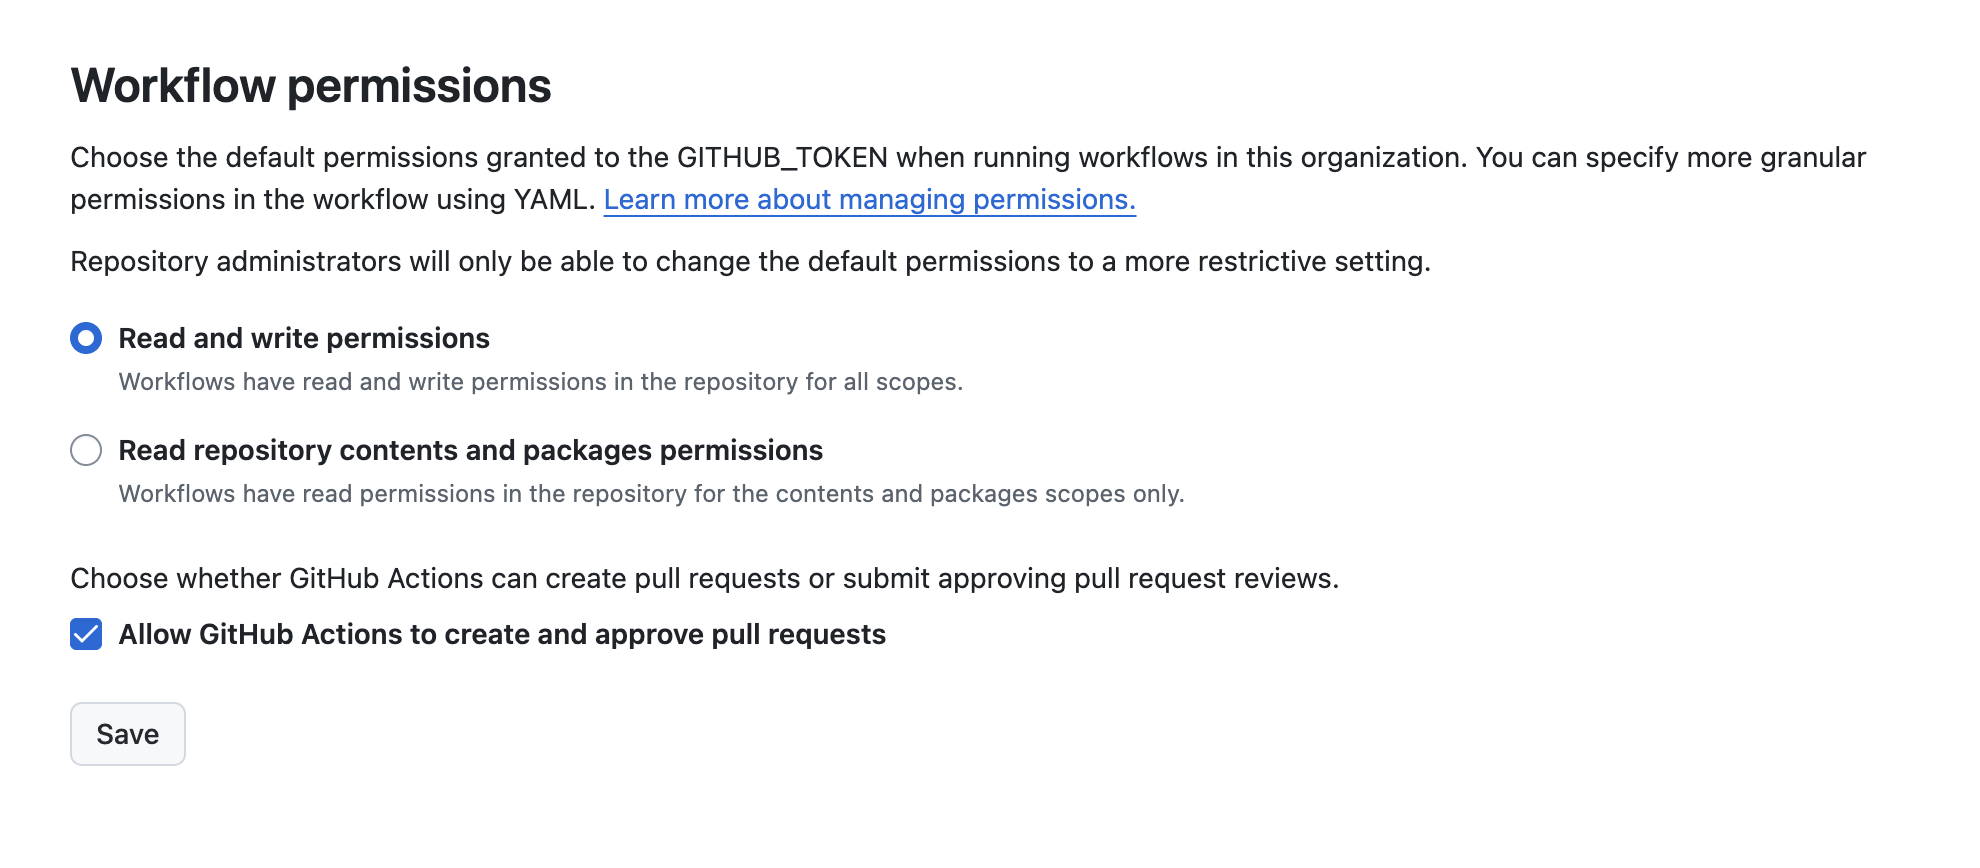

In [10]:
from IPython.display import Image
Image("images/github-pr-settings.png")


## Step 3: Insert Codex in your CI pipeline

The following YAML shows a Gitub action that auto triggers when CI fails, installs Codex, uses codex exec and then makes a PR on the failing branch with the fix. Replace "CI" with the name of the workflow you want to monitor.

```yaml

name: Codex Auto-Fix on Failure

on:
  workflow_run:
    # Trigger this job after any run of the primary CI workflow completes
    workflows: ["CI"]
    types: [completed]

permissions:
  contents: write
  pull-requests: write

jobs:
  auto-fix:
    # Only run when the referenced workflow concluded with a failure
    if: ${{ github.event.workflow_run.conclusion == 'failure' }}
    runs-on: ubuntu-latest
    env:
      OPENAI_API_KEY: ${{ secrets.OPENAI_API_KEY }}
      FAILED_WORKFLOW_NAME: ${{ github.event.workflow_run.name }}
      FAILED_RUN_URL: ${{ github.event.workflow_run.html_url }}
      FAILED_HEAD_BRANCH: ${{ github.event.workflow_run.head_branch }}
      FAILED_HEAD_SHA: ${{ github.event.workflow_run.head_sha }}
    steps:
      - name: Check prerequisites
        run: |
          if [ -z "$OPENAI_API_KEY" ]; then
            echo "OPENAI_API_KEY secret is not set. Skipping auto-fix." >&2
            exit 1
          fi

      - name: Checkout failing ref
        uses: actions/checkout@v4
        with:
          ref: ${{ env.FAILED_HEAD_SHA }}
          fetch-depth: 0

      - name: Setup Node.js
        uses: actions/setup-node@v4
        with:
          node-version: '20'
          cache: 'npm'

      - name: Install dependencies
        run: |
          if [ -f package-lock.json ]; then npm ci; else npm i; fi

      - name: Prepare Codex prerequisites
        shell: bash
        run: |
          # Ensure python3 exists for Codex' login helper
          if ! command -v python3 >/dev/null 2>&1; then
            sudo apt-get update
            sudo apt-get install -y python3
          fi

          # Ensure Codex config dir exists and is writable
          mkdir -p "$HOME/.codex"
          # (Optional) pin an explicit home for Codex config/logs
          echo "CODEX_HOME=$HOME/.codex" >> $GITHUB_ENV

      - name: Install Codex CLI
        run: npm i -g @openai/codex

      - name: Authenticate Codex (non-interactive)
        env:
          # if you set CODEX_HOME above, export it here too
          CODEX_HOME: ${{ env.CODEX_HOME }}
          OPENAI_API_KEY: ${{ secrets.OPENAI_API_KEY }}
        run: codex login --api-key "$OPENAI_API_KEY"

      - name: Run Codex to fix CI failure
        run: |
          codex exec --full-auto --sandbox workspace-write "You are working in a Node.js monorepo with Jest tests and GitHub Actions. Read the repository, run the test suite, identify the minimal change needed to make all tests pass, implement only that change, and stop. Do not refactor unrelated code or files. Keep changes small and surgical."

      - name: Verify tests
        run: npm test --silent

      - name: Create pull request with fixes
        if: success()
        uses: peter-evans/create-pull-request@v6
        with:
          commit-message: "fix(ci): auto-fix failing tests via Codex"
          branch: codex/auto-fix-${{ github.event.workflow_run.run_id }}
          base: ${{ env.FAILED_HEAD_BRANCH }}
          title: "Auto-fix failing CI via Codex"
          body: |
            Codex automatically generated this PR in response to a CI failure on workflow `${{ env.FAILED_WORKFLOW_NAME }}`.

            Failed run: ${{ env.FAILED_RUN_URL }}
            Head branch: `${{ env.FAILED_HEAD_BRANCH }}`

            This PR contains minimal changes intended solely to make the CI pass.
```
